## Bank Churn Prediction


**Objective:**
Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

**Context:**
Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

### Dataset Description

 
The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.
Link to the Kaggle project site:https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

**Data Dictionary:**

* RowNumber: Row number.
* CustomerId: Unique identification key for different customers.
* Surname: Surname of the customer
* Credit Score: Credit score is a measure of an individual's ability to pay back the borrowed amount. It is the numerical representation of their creditworthiness. A credit score is a 3-digit number that falls in the range of 300-900, 900 being the highest.
* Geography: The country to which the customer belongs.
* Gender: The gender of the customer.
* Age: Age of the customer.
* Tenure: The period of time a customer has been associated with the bank.
* Balance: The account balance (the amount of money deposited in the bank account) of the customer.
* NumOfProducts: How many accounts, bank account affiliated products the person has.
* HasCrCard: Does the customer have a credit card through the bank?
* IsActiveMember: Subjective, but for the concept
* EstimatedSalary: Estimated salary of the customer.
* Exited: Did they leave the bank after all?




In [ ]:
!pip install tensorflow==2.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
project_path = '/content/drive/My Drive/Colab Notebooks/'

In [ ]:
dataset_file = project_path + 'bank.csv'

#1. Reading the DataSet

In [ ]:
data = pd.read_csv(dataset_file)

In [ ]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#3. Bi-variate Analysis

## Plotting heatmap of the continuous variables

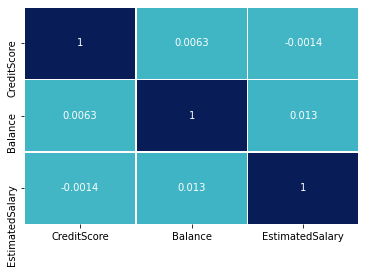

In [ ]:
X_numerical = data[["CreditScore", "Balance", "EstimatedSalary"]]

sns.heatmap(X_numerical.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")

* There is no visible correlation between the continuos variables.

## Plotting a cross tab of Categorical Variables with the Target Variable exited

In [ ]:
pd.crosstab(data['Geography'],data['Exited'],normalize='index')

Exited,0,1
Geography,,
France,0.838452,0.161548
Germany,0.675568,0.324432
Spain,0.833266,0.166734


In [ ]:
pd.crosstab(data['Gender'],data['Exited'],normalize='index')

Exited,0,1
Gender,,
Female,0.749285,0.250715
Male,0.835441,0.164559


* The columns Geography and Gender do not have ordinality. Hence checking the percentage distribution of both Target outcomes , for each of the categories.

As we can see above, for both **Gender** and **Geography** the distribution is not the same for all of their Categories, hence we need to include these columns.

## Apply binning to create categories for Variables which have ordinality namely - creditscore, age, balance, estimated salary

In [ ]:
# Determine quartile values for the above
col = ["CreditScore","Age","Balance","EstimatedSalary"]

Q1 = data[col].quantile(0.25)
Q2 = data[col].quantile(0.5)
Q3 = data[col].quantile(0.75)
Q4 = data[col].quantile(1)

print("Q1 " , Q1)
print("Q2 " , Q2)
print("Q3 " , Q3)
print("Q4 " , Q4)

Q1  CreditScore          584.00
Age                   32.00
Balance                0.00
EstimatedSalary    51002.11
Name: 0.25, dtype: float64
Q2  CreditScore           652.000
Age                    37.000
Balance             97198.540
EstimatedSalary    100193.915
Name: 0.5, dtype: float64
Q3  CreditScore           718.0000
Age                    44.0000
Balance            127644.2400
EstimatedSalary    149388.2475
Name: 0.75, dtype: float64
Q4  CreditScore           850.00
Age                    92.00
Balance            250898.09
EstimatedSalary    199992.48
Name: 1, dtype: float64


In [ ]:
# Binning

bin_edges = [0,584,652,718,850]         # edges to define intervals
bin_labels = [0,1,2,3]               # labels to denote each interval
data['CreditScore'] = pd.cut(data['CreditScore'], bins=bin_edges , labels=bin_labels)


bin_edges = [0,32,37,44,92]         # edges to define intervals
bin_labels = [0,1,2,3]               # labels to denote each interval
data['Age'] = pd.cut(data['Age'], bins=bin_edges , labels=bin_labels)


bin_edges = [-1,0,97198.540,127644.2400,250898.09]         # edges to define intervals
bin_labels = [0,1,2,3]               # labels to denote each interval
data['Balance'] = pd.cut(data['Balance'], bins=bin_edges , labels=bin_labels)


bin_edges = [0,51002.11,100193.915,149388.2475,199992.48]         # edges to define intervals
bin_labels = [0,1,2,3]               # labels to denote each interval
data['EstimatedSalary'] = pd.cut(data['EstimatedSalary'], bins=bin_edges , labels=bin_labels)


#3. Eliminating the unique or trivial columns.

In [ ]:
data = data.drop(["CustomerId","RowNumber","Surname"], axis = 1)

In [ ]:
print(data)

     CreditScore Geography  Gender  ... IsActiveMember  EstimatedSalary Exited
0              1    France  Female  ...              1                2      1
1              1     Spain  Female  ...              1                2      0
2              0    France  Female  ...              0                2      1
3              2    France  Female  ...              0                1      0
4              3     Spain  Female  ...              1                1      0
...          ...       ...     ...  ...            ...              ...    ...
9995           3    France    Male  ...              0                1      0
9996           0    France    Male  ...              1                2      0
9997           2    France  Female  ...              1                0      1
9998           3   Germany    Male  ...              0                1      1
9999           3    France  Female  ...              0                0      0

[10000 rows x 11 columns]


In [ ]:
data = data.dropna()

In [ ]:
data = pd.get_dummies(data, columns=['Geography','Gender'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   CreditScore        10000 non-null  category
 1   Age                10000 non-null  category
 2   Tenure             10000 non-null  int64   
 3   Balance            10000 non-null  category
 4   NumOfProducts      10000 non-null  int64   
 5   HasCrCard          10000 non-null  int64   
 6   IsActiveMember     10000 non-null  int64   
 7   EstimatedSalary    10000 non-null  category
 8   Exited             10000 non-null  int64   
 9   Geography_France   10000 non-null  uint8   
 10  Geography_Germany  10000 non-null  uint8   
 11  Geography_Spain    10000 non-null  uint8   
 12  Gender_Female      10000 non-null  uint8   
 13  Gender_Male        10000 non-null  uint8   
dtypes: category(4), int64(5), uint8(5)
memory usage: 557.4 KB


* None of the columns have a NULL value

#4. Distinguish the feature and target set and divide the data set into training and test sets 

In [ ]:
X_data = data.iloc[:, :-1]  

In [ ]:
X_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female
0,1,2,2,0,1,1,1,2,1,1,0,0,1
1,1,2,1,1,1,0,1,2,0,0,0,1,1
2,0,2,8,3,3,1,0,2,1,1,0,0,1
3,2,2,1,0,2,0,0,1,0,1,0,0,1
4,3,2,2,2,1,1,1,1,0,0,0,1,1


In [ ]:
Y_data = data.iloc[:, -1]

In [ ]:
Y_data.head()

0    0
1    0
2    0
3    0
4    0
Name: Gender_Male, dtype: uint8

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size = 0.2, random_state = 7)

#5. Normalize the train and test data

In [ ]:
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 13)
(2000, 13)
(8000,)
(2000,)


#6. Initialize & build the model. Identify the points of improvement and implement the same.

##Creating Model 

Keras model object can be created with Sequential class

At the outset, the model is empty per se. It is completed by adding additional layers and compilation

In [ ]:
model = Sequential()

### Adding layers [layers and activations]

Keras layers can be added to the model

Adding layers are like stacking lego blocks one by one

It should be noted that as this is a classification problem, sigmoid layer (softmax for multi-class problems) should be added

In [ ]:
model.add(Dense(32, input_shape = (13,), activation = 'relu'))
model.add(Dense(16, activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid'))

### Model compile [optimizers and loss functions]

Keras model should be "compiled" prior to training

Types of loss (function) and optimizer should be designated

In [ ]:
sgd = optimizers.Adam(lr = 0.001)

In [ ]:
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])

## Summary of the model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                448       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


## Training [Forward pass and Backpropagation]

Training the model

In [ ]:
model.fit(X_train, y_train.values, batch_size = 50, epochs = 10, verbose = 1)

Train on 8000 samples
Epoch 1/10
8000/8000 [==============================] - 1s 82us/sample - loss: 0.6153 - accuracy: 0.7054
Epoch 2/10
8000/8000 [==============================] - 0s 27us/sample - loss: 0.2602 - accuracy: 0.9925
Epoch 3/10
8000/8000 [==============================] - 0s 29us/sample - loss: 0.0602 - accuracy: 1.0000
Epoch 4/10
8000/8000 [==============================] - 0s 26us/sample - loss: 0.0209 - accuracy: 1.0000
Epoch 5/10
8000/8000 [==============================] - 0s 27us/sample - loss: 0.0103 - accuracy: 1.0000
Epoch 6/10
8000/8000 [==============================] - 0s 28us/sample - loss: 0.0061 - accuracy: 1.0000
Epoch 7/10
8000/8000 [==============================] - 0s 28us/sample - loss: 0.0040 - accuracy: 1.0000
Epoch 8/10
8000/8000 [==============================] - 0s 27us/sample - loss: 0.0028 - accuracy: 1.0000
Epoch 9/10
8000/8000 [==============================] - 0s 27us/sample - loss: 0.0021 - accuracy: 1.0000
Epoch 10/10
8000/8000 [==========

##8. Print Accuracy score and Confusion matrix

In [ ]:
results = model.evaluate(X_test, y_test.values)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
print(model.metrics_names)
print(results)    

['loss', 'accuracy']
[0.0014048355333507062, 1.0]


In [ ]:
Y_pred_cls = model.predict_classes(X_test, batch_size=200, verbose=0)
print('Accuracy Model1 (Dropout): '+ str(model.evaluate(X_test,y_test.values)[1]))
print('Recall_score: ' + str(recall_score(y_test.values,Y_pred_cls)))
print('Precision_score: ' + str(precision_score(y_test.values, Y_pred_cls)))
print('F-score: ' + str(f1_score(y_test.values,Y_pred_cls)))
confusion_matrix(y_test.values, Y_pred_cls)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

array([[ 894,    0],
       [   0, 1106]])

In [ ]:
#Y_pred = model.predict(X_test)

print(Y_pred_cls)

[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]
